In [ ]:
%pip install tqdm
%pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
import wandb
import os
import torch
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torchvision.datasets as datasets
from scipy.stats import gaussian_kde
from scipy.stats import norm
from random import randint

In [ ]:
wandb.login(key=)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

parameters_dict = {
    'latent_dim': {
        'value':10},
    'num_epochs':{
        'value':20},
    'batch_size':{
        'value':16},
    'learning_rate':{
        'value':3.5e-4},
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='MNIST 7 layer VAE')
project='MNIST 7 layer VAE'
folder_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}"
os.makedirs(folder_path)

Create sweep with ID: freumqcs
Sweep URL: https://wandb.ai/t-a-emm-20/MNIST%207%20layer%20VAE/sweeps/freumqcs


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 17465095.08it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 482918.24it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4381081.11it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 8998832.67it/s]


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw

torch.Size([50000, 1, 28, 28])


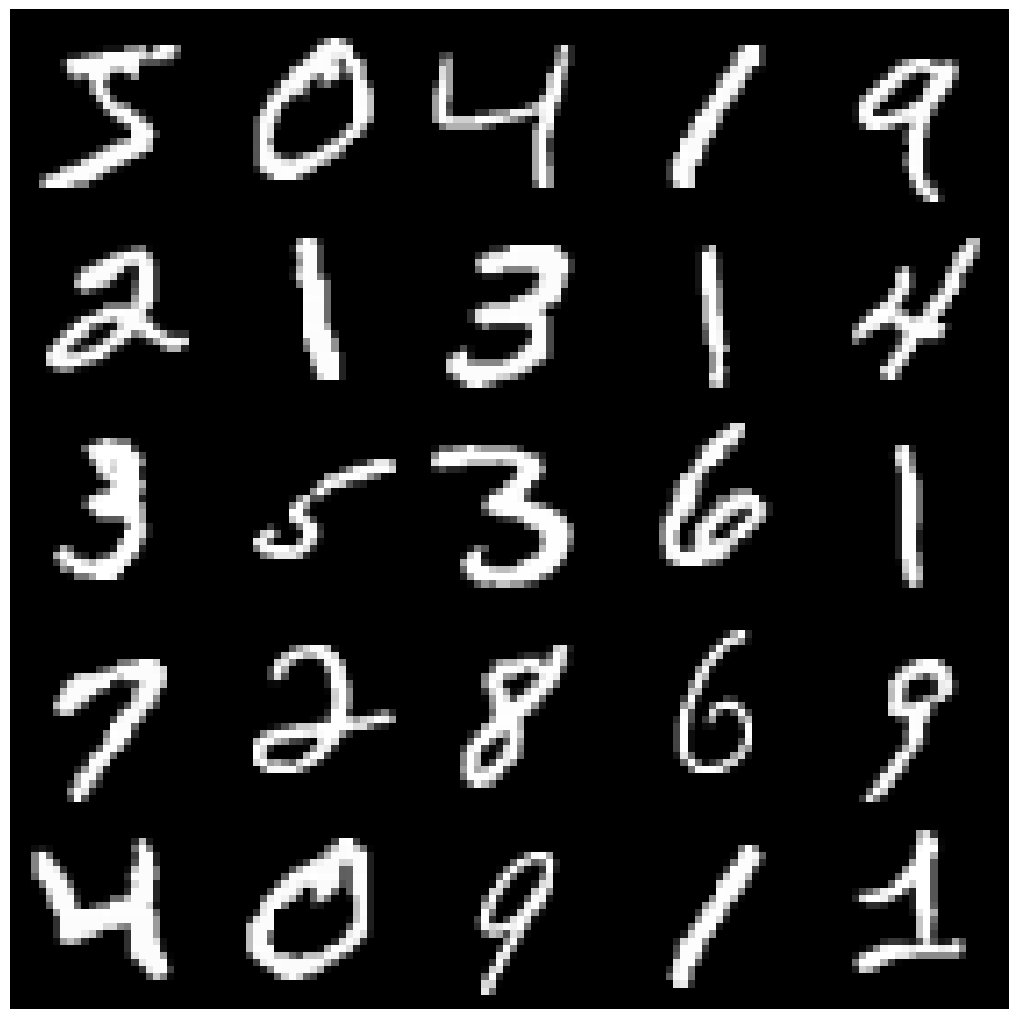

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

print(train_dataset.shape)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
      super().__init__()
      #encoding
      self.in_lay=nn.Linear(input_dim,1600)
      self.enclay1=nn.Linear(1600,800)
      self.mu=nn.Linear(800,latent_dim)
      self.logstd=nn.Linear(800,latent_dim)

      #deocoding
      self.declay1=nn.Linear(latent_dim,800)
      self.declay2=nn.Linear(800,1600)
      self.out_lay=nn.Linear(1600,input_dim)

      self.relu=nn.ReLU()

    def encode(self,x):
        el1=self.relu(self.in_lay(x))
        el2=self.relu(self.enclay1(el1))
        mu=self.mu(el2)
        logstd=self.logstd(el2)

        return mu, logstd

    def decode(self, z):
        dl1=self.relu(self.declay1(z))
        dl2=self.relu(self.declay2(dl1))

        return torch.sigmoid(self.out_lay(dl2))

    def forward(self,x):
        mu, logstd = self.encode(x)
        std=torch.exp(logstd)
        eps = torch.randn_like(logstd)
        z_reparam = mu + std*eps
        z_prior = torch.randn_like(logstd)
        x_recon = self.decode(z_reparam)

        return x_recon, mu, logstd, z_prior, z_reparam

In [ ]:
def loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior):
    recon_loss=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='sum')
    kl_div = -0.5*torch.sum(1+logstd-mu.pow(2)-(torch.exp(logstd)).pow(2))

    return recon_loss, kl_div

In [ ]:
def train(config=None):
    wandb.init(config = config)
    config=wandb.config

    input_dim=784
    latent_dim=config.latent_dim
    num_epochs=config.num_epochs
    batch_size=config.batch_size
    learning_rate=config.learning_rate
    scales = [0.1, 0.2, 0.5, 1.0, 2.0, 5, 10.0]
    kernel_bandwidth=1

    #dataset
    train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size)
    model=VariationalAutoEncoder(input_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    z_star=[]

    #train
    for epoch in range(num_epochs):
        loop=tqdm(enumerate(train_loader))
        #batch_recon=[]
        #batch_kl_div=[]
        #batch_mmd=[]

        for i, x in loop:
            x=x.to(device).view(x.shape[0],input_dim)
            x_recon, mu, logstd, z_prior, z_reparam =model(x)
            n=z_reparam.shape[0]
            z_star.append(z_reparam.detach())
            #print(z_reparam)

            recon_loss, kl_div =loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior)

            #batch_recon.append(recon_loss)
            #batch_kl_div.append(kl_div)
            #batch_mmd.append(mmd_loss)

        #epoch_recon=torch.mean(torch.stack(batch_recon))
        #epoch_kl_div=torch.mean(torch.stack(batch_kl_div))
        #epoch_mmd=torch.mean(torch.stack(batch_mmd))

            loss= recon_loss + kl_div

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

            wandb.log({'loss':loss,'epoch':epoch,'recon loss':recon_loss,'kl diverg':kl_div})


    #Sample
    gen_imgs=[]
    num_samples=25
    full_batch_nbr=int(num_samples/batch_size)
    last_batch_nbr=num_samples % batch_size

    for i in range(num_samples):
        z_gen=torch.zeros(10)
        for j in range(latent_dim):
            z_gen[j]=torch.tensor(np.random.normal(loc=0, scale=1.1, size=1))
        #print(z_gen)
        z_gen=z_gen.to(device)
        x_gen=model.decode(z_gen).detach()
        gen_img=x_gen.reshape(1,28,28)
        gen_imgs.append(gen_img)
    gen_imgs=torch.stack(gen_imgs)

    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i][j].imshow(gen_imgs[i*5 +j].cpu().squeeze(0), cmap='gray')
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.)

    run_name=wandb.run.name
    run_gen='generated'
    run_gen_name=run_name+run_gen
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_gen_name}.png"
    plt.savefig(img_path)


    #Reconstruction
    to_recon=[]
    hi=[1,3,5,7,9,0,18,15,17,4]
    for i in range(10):
        to_recon.append(train_dataset[hi[i]])

    to_recon_imgs=torch.stack(to_recon)

    recond=[]
    rec_errors=[]
    for i in range(10):
        x=to_recon_imgs[i].to(device).view(1,input_dim)
        x_recon, mu, logstd, z_prior, z_reparam =model(x)
        recon_error=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='mean')
        x_recon_img=x_recon.reshape(1,28,28)
        recond.append(x_recon_img.detach())
        rec_errors.append(recon_error.detach())

    recond_imgs=torch.stack(recond)
    rec_errors=torch.stack(rec_errors)
    print(rec_errors)

    fig3, axes3 = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
    for i in range(10):
        axes3[0][i].imshow(to_recon_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[0][i].axis('off')
        axes3[1][i].imshow(recond_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[1][i].axis('off')

    plt.tight_layout(pad=0.)
    run_recon='recon'
    run_recon_name=run_name+run_recon
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_recon_name}.png"
    plt.savefig(img_path)

    #Disentanglment Metric
    fixed_metric=randint(0,9)
    num_tests=15
    zldiff=[]

    for j in range(num_tests):
        v1=torch.zeros(latent_dim)
        v2=torch.zeros(latent_dim)

        for i in range(latent_dim):
            v1[i]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            v2[i]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            t=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            v1[fixed_metric]=t
            v2[fixed_metric]=t
            v1=v1.to(device)
            v2=v2.to(device)

        x1=model.decode(v1).detach()
        x1_img=x1.reshape(1,28,28)
        x2=model.decode(v2).detach()
        x2_img=x2.reshape(1,28,28)

        z1mu, z1logstd=model.encode(x1)
        z2mu, z2logstd=model.encode(x2)

        eps1=torch.randn_like(z1logstd)
        std1=torch.exp(z1logstd)
        z1=z1mu+eps1*std1

        eps2=torch.randn_like(z2logstd)
        std2=torch.exp(z2logstd)
        z2=z2mu+eps2*std2

        for i in range(len(z1)):
            zldiff.append(abs(z1[i]-z2[i]))

    zldiff=torch.stack(zldiff)
    zbdiff=(1/(num_tests*latent_dim))*torch.sum(zldiff)*100
    print(zbdiff)
    wandb.log({'zbdiff':zbdiff})

wandb: Agent Starting Run: 63rbqyl0 with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20
wandb: Currently logged in as: t-a-emm-20. Use `wandb login --relogin` to force relogin


3125it [00:31, 100.27it/s, loss=461]
3125it [00:30, 102.49it/s, loss=453]
3125it [00:37, 84.46it/s, loss=416] 
3125it [00:29, 105.90it/s, loss=410]
3125it [00:29, 107.56it/s, loss=394]
3125it [00:29, 105.62it/s, loss=376]
3125it [00:30, 103.32it/s, loss=382]
3125it [00:29, 105.96it/s, loss=363]
3125it [00:29, 106.82it/s, loss=371]
3125it [00:29, 106.41it/s, loss=361]
3125it [00:29, 105.88it/s, loss=364]
3125it [00:29, 105.84it/s, loss=350]
3125it [00:29, 105.88it/s, loss=343]
3125it [00:29, 105.26it/s, loss=342]
3125it [00:29, 106.59it/s, loss=349]
3125it [00:29, 104.98it/s, loss=345]
3125it [00:30, 102.19it/s, loss=348]
3125it [00:29, 105.84it/s, loss=337]
3125it [00:29, 105.60it/s, loss=320]
3125it [00:29, 106.32it/s, loss=323]


tensor([0.0134, 0.0031, 0.0191, 0.0244, 0.0136, 0.0247, 0.0102, 0.0077, 0.0142,
        0.0197], device='cuda:0')
tensor(88.7447, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▄▄▅▅▅▇▆▇▇▇▇▆▇▇▇▇▆█▇▇▇▇▇█▇██▇██▇█▇▇██▇▇█
loss,█▅▅▄▃▄▅▄▅▄▂▄▃▃▄▃▃▁▄▃▂▃▄▅▄▂▃▃▄▄▂▂▃▂▃▃▄▃▃▂
recon loss,█▅▄▄▃▄▄▃▄▃▂▃▃▂▃▂▂▁▃▃▂▂▃▄▃▂▃▃▃▃▁▂▂▁▂▂▃▂▂▂
zbdiff,▁
epoch,19
kl diverg,124.26908
loss,323.49701
recon loss,199.22794
zbdiff,88.74467


wandb: Agent Starting Run: 7t8mhbew with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:29, 104.97it/s, loss=473]
3125it [00:29, 104.59it/s, loss=433]
3125it [00:29, 104.91it/s, loss=398]
3125it [00:29, 105.06it/s, loss=407]
3125it [00:29, 104.73it/s, loss=380]
3125it [00:30, 101.88it/s, loss=373]
3125it [00:29, 104.71it/s, loss=365]
3125it [00:29, 104.59it/s, loss=361]
3125it [00:29, 104.36it/s, loss=356]
3125it [00:29, 105.11it/s, loss=348]
3125it [00:29, 104.85it/s, loss=365]
3125it [00:29, 104.23it/s, loss=358]
3125it [00:30, 103.98it/s, loss=335]
3125it [00:29, 104.41it/s, loss=326]
3125it [00:31, 99.92it/s, loss=341]
3125it [00:30, 102.75it/s, loss=340]
3125it [00:29, 105.21it/s, loss=331]
3125it [00:29, 104.36it/s, loss=314]
3125it [00:29, 104.69it/s, loss=335]
3125it [00:29, 105.34it/s, loss=326]


tensor([0.0135, 0.0036, 0.0278, 0.0091, 0.0119, 0.0285, 0.0095, 0.0097, 0.0144,
        0.0144], device='cuda:0')
tensor(86.2030, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▄▅▅▅▆▆▆▆▆▅▇▆▆▆▇▆▆▇▆▇▇▇▇█▇█▇▇█▇▇▇▇▇▇▇▇▇▇
loss,█▄▄▄▃▄▄▃▅▃▁▄▃▃▄▃▃▁▃▃▂▃▃▄▄▂▃▃▄▄▂▂▃▂▃▃▄▂▃▂
recon loss,█▄▄▃▃▄▄▃▄▃▁▃▃▂▃▃▃▁▃▂▂▂▃▄▃▂▃▃▃▃▂▁▂▁▂▂▃▂▂▂
zbdiff,▁
epoch,19
kl diverg,133.45119
loss,326.17798
recon loss,192.72678
zbdiff,86.20304


wandb: Agent Starting Run: etr4f68x with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:30, 104.07it/s, loss=493]
3125it [00:30, 104.02it/s, loss=441]
3125it [00:30, 103.77it/s, loss=405]
3125it [00:31, 100.36it/s, loss=392]
3125it [00:29, 104.32it/s, loss=366]
3125it [00:30, 103.14it/s, loss=372]
3125it [00:30, 104.01it/s, loss=362]
3125it [00:29, 104.20it/s, loss=356]
3125it [00:30, 103.65it/s, loss=347]
3125it [00:30, 104.09it/s, loss=353]
3125it [00:29, 104.46it/s, loss=342]
3125it [00:30, 103.90it/s, loss=337]
3125it [00:31, 100.53it/s, loss=344]
3125it [00:30, 104.04it/s, loss=344]
3125it [00:30, 102.67it/s, loss=351]
3125it [00:30, 103.98it/s, loss=343]
3125it [00:30, 104.16it/s, loss=348]
3125it [00:29, 104.21it/s, loss=336]
3125it [00:30, 103.70it/s, loss=332]
3125it [00:30, 103.67it/s, loss=342]


tensor([0.0134, 0.0062, 0.0205, 0.0151, 0.0088, 0.0292, 0.0084, 0.0095, 0.0170,
        0.0156], device='cuda:0')
tensor(90.2498, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▃▄▄▅▅▆▅▆▆▆▆▆▆▅▆▆▅▆▆▇▆▇▆▇▇▇▇▇█▆▆▇▆▇▇▇▇▆▆
loss,█▄▅▄▃▄▄▄▅▃▁▄▃▂▃▃▃▁▃▃▃▃▃▄▄▂▃▃▄▄▁▂▃▂▃▂▄▂▂▂
recon loss,█▄▅▄▃▃▃▃▄▃▁▄▂▂▃▃▂▁▂▃▂▂▃▃▃▁▂▂▃▃▁▁▂▁▂▂▃▂▂▂
zbdiff,▁
epoch,19
kl diverg,127.13791
loss,341.73923
recon loss,214.60132
zbdiff,90.24976


wandb: Agent Starting Run: lf47x1t6 with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:30, 102.71it/s, loss=473]
3125it [00:31, 99.48it/s, loss=448] 
3125it [00:30, 102.85it/s, loss=426]
3125it [00:30, 102.60it/s, loss=404]
3125it [00:30, 103.45it/s, loss=396]
3125it [00:30, 102.72it/s, loss=373]
3125it [00:30, 103.14it/s, loss=356]
3125it [00:30, 104.10it/s, loss=377]
3125it [00:30, 103.87it/s, loss=358]
3125it [00:30, 103.42it/s, loss=358]
3125it [00:31, 100.52it/s, loss=358]
3125it [00:29, 104.18it/s, loss=359]
3125it [00:30, 103.06it/s, loss=357]
3125it [00:30, 103.48it/s, loss=361]
3125it [00:30, 102.41it/s, loss=346]
3125it [00:30, 103.82it/s, loss=359]
3125it [00:30, 103.19it/s, loss=327]
3125it [00:30, 103.70it/s, loss=339]
3125it [00:30, 102.93it/s, loss=331]
3125it [00:30, 101.17it/s, loss=330]


tensor([0.0126, 0.0045, 0.0195, 0.0165, 0.0207, 0.0419, 0.0135, 0.0108, 0.0143,
        0.0189], device='cuda:0')
tensor(85.3952, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▄▄▅▅▄▆▆▆▆▆▇▆▆▆▆▆▅▆▆▇▆▆▆▇▆█▇▇█▇▇█▆▇▇▇▇▇▇
loss,█▄▅▃▃▄▄▄▅▃▁▄▃▃▄▃▃▁▃▃▃▃▄▄▄▂▃▃▄▄▂▂▃▂▃▃▄▂▃▂
recon loss,█▄▅▃▃▄▄▃▅▃▁▄▂▂▃▂▃▁▃▂▂▃▃▄▃▂▂▃▃▃▂▁▂▂▂▂▃▂▂▂
zbdiff,▁
epoch,19
kl diverg,123.55772
loss,330.00189
recon loss,206.44415
zbdiff,85.39516


wandb: Agent Starting Run: wqau5tbk with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:30, 101.61it/s, loss=466]
3125it [00:29, 104.20it/s, loss=416]
3125it [00:30, 102.05it/s, loss=398]
3125it [00:30, 101.59it/s, loss=404]
3125it [00:30, 101.97it/s, loss=376]
3125it [00:31, 98.22it/s, loss=362] 
3125it [00:30, 102.97it/s, loss=349]
3125it [00:30, 101.41it/s, loss=355]
3125it [00:30, 102.97it/s, loss=362]
3125it [00:30, 103.67it/s, loss=350]
3125it [00:30, 102.96it/s, loss=341]
3125it [00:30, 102.28it/s, loss=344]
3125it [00:30, 103.53it/s, loss=338]
3125it [00:30, 102.55it/s, loss=348]
3125it [00:30, 102.02it/s, loss=326]
3125it [00:30, 101.42it/s, loss=345]
3125it [00:31, 98.15it/s, loss=333]
3125it [00:30, 102.29it/s, loss=325]
3125it [00:30, 102.62it/s, loss=335]
3125it [00:30, 102.65it/s, loss=324]


tensor([0.0181, 0.0051, 0.0160, 0.0133, 0.0131, 0.0294, 0.0081, 0.0129, 0.0145,
        0.0153], device='cuda:0')
tensor(86.1880, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▃▄▅▅▅▆▆▆▆▅▆▅▆▆▆▆▅▆▆▇▆▆▆▇▆▇▇▇█▇▆▇▆▆▇▇▇▆▇
loss,█▄▅▃▃▄▄▃▄▃▁▄▃▂▃▃▃▁▃▃▂▄▄▄▃▂▃▃▄▄▂▂▃▁▂▂▄▂▂▂
recon loss,█▄▄▃▂▃▄▃▄▂▁▃▂▂▃▂▂▁▂▂▂▃▃▃▂▂▂▂▃▃▁▁▂▁▂▂▃▁▂▂
zbdiff,▁
epoch,19
kl diverg,129.2999
loss,324.30011
recon loss,195.0002
zbdiff,86.18797


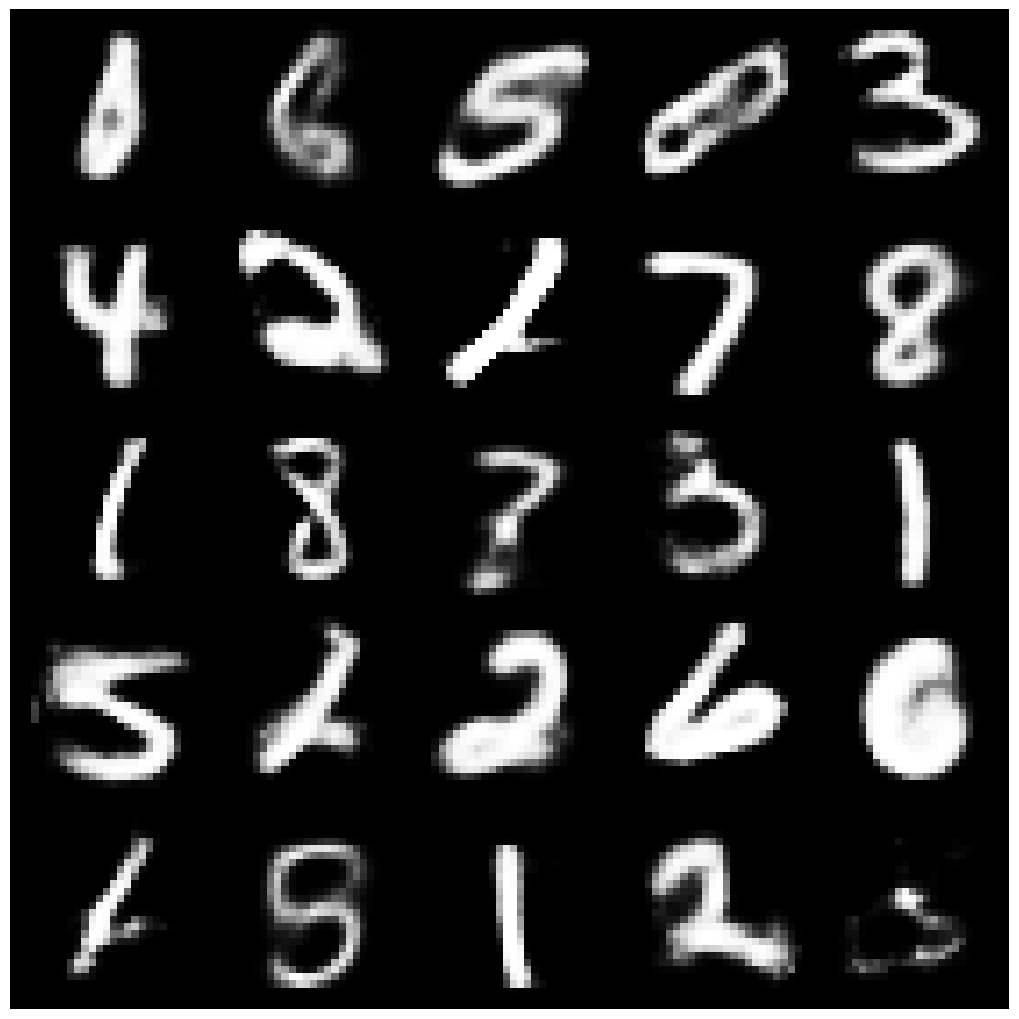

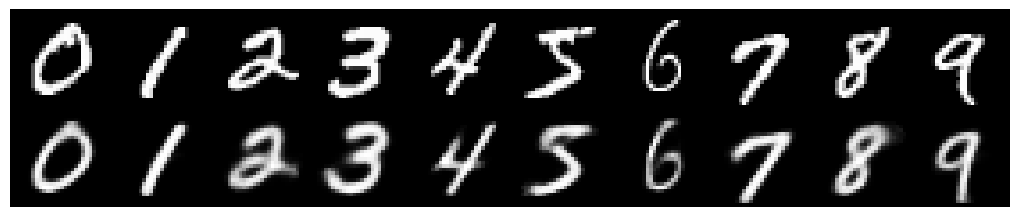

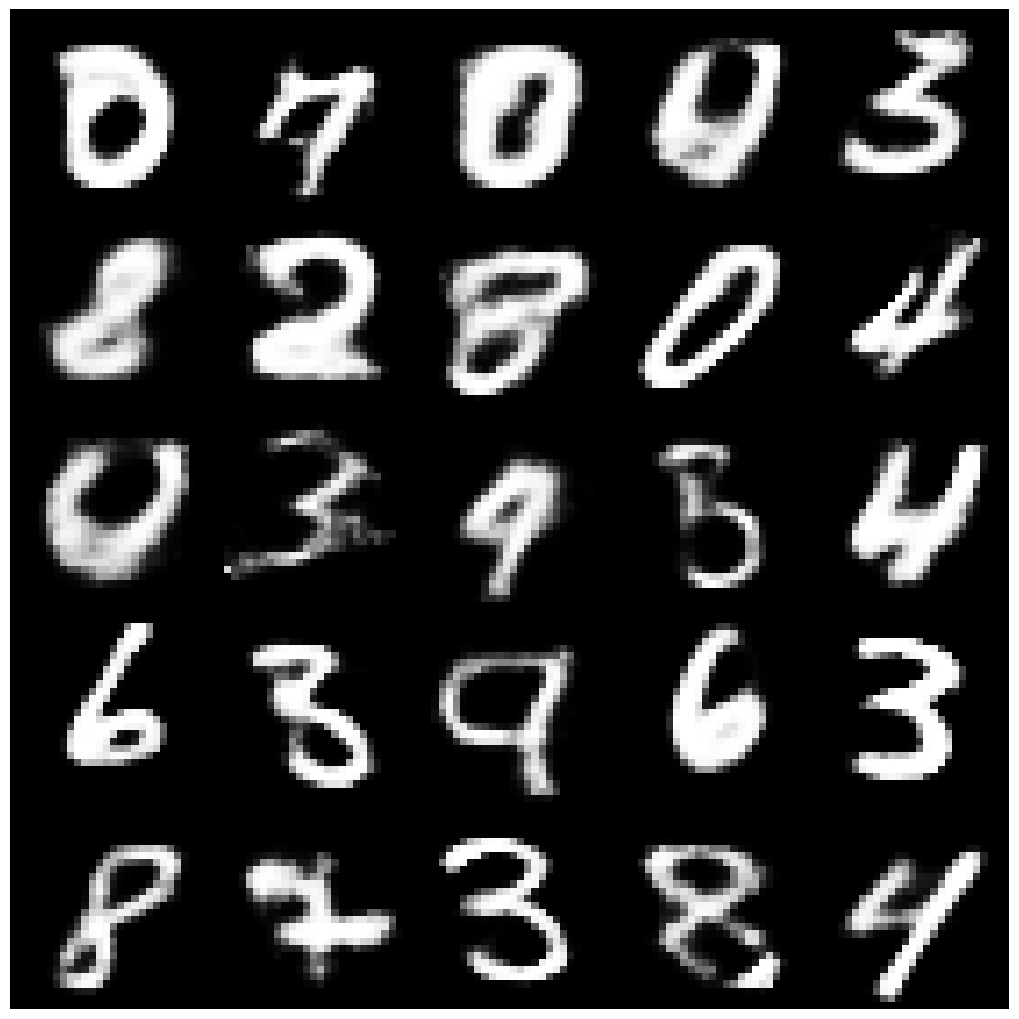

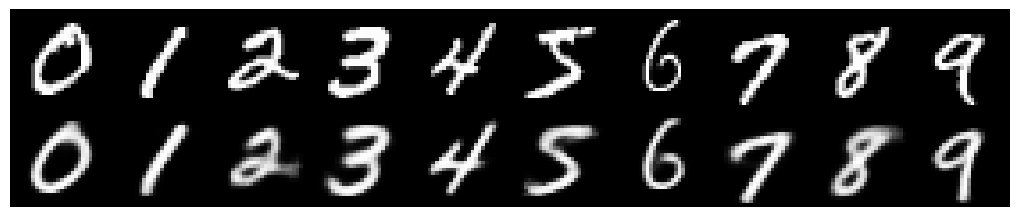

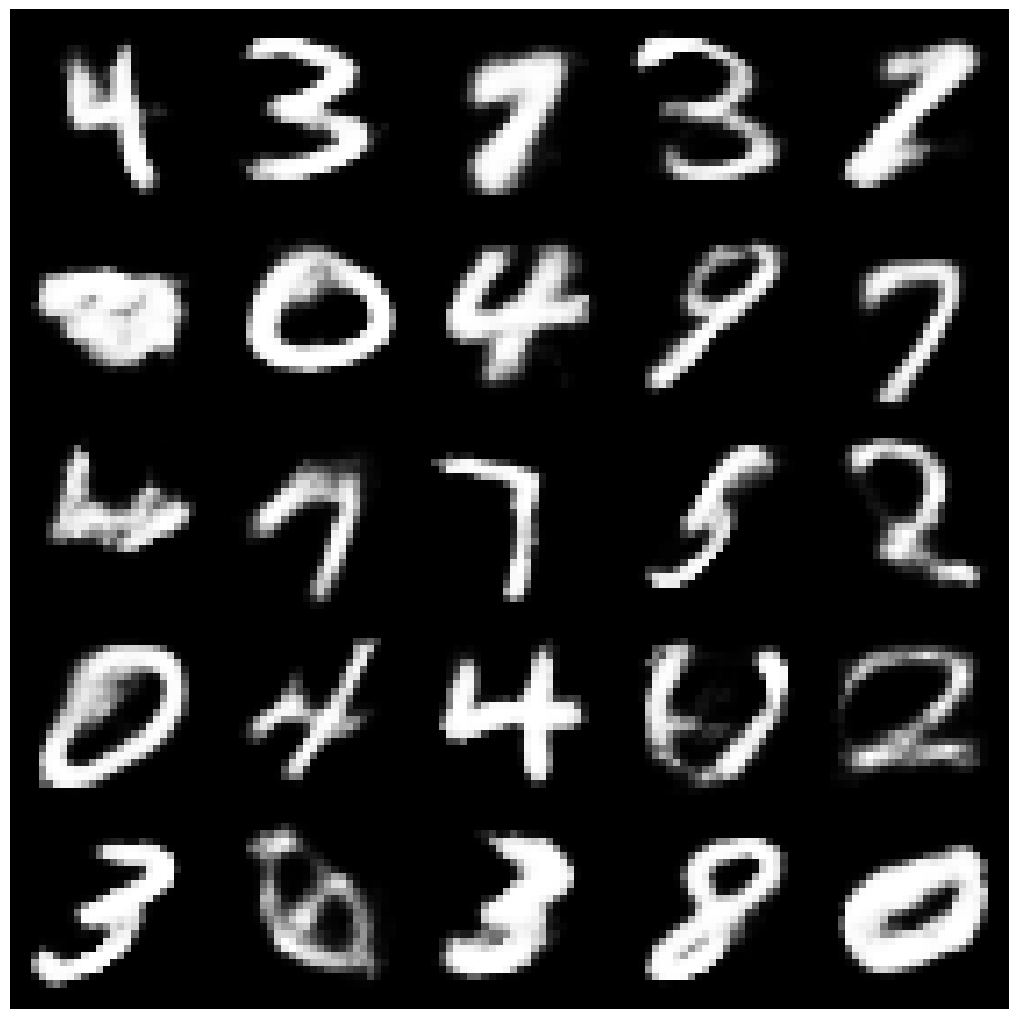

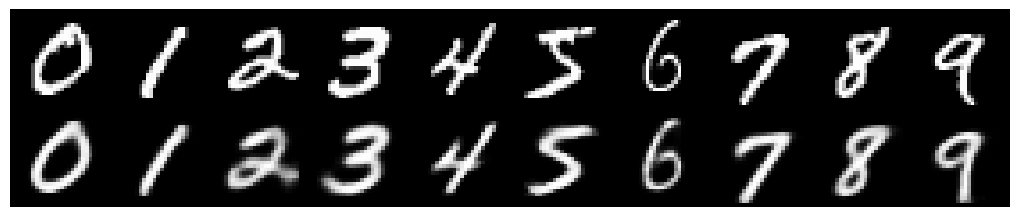

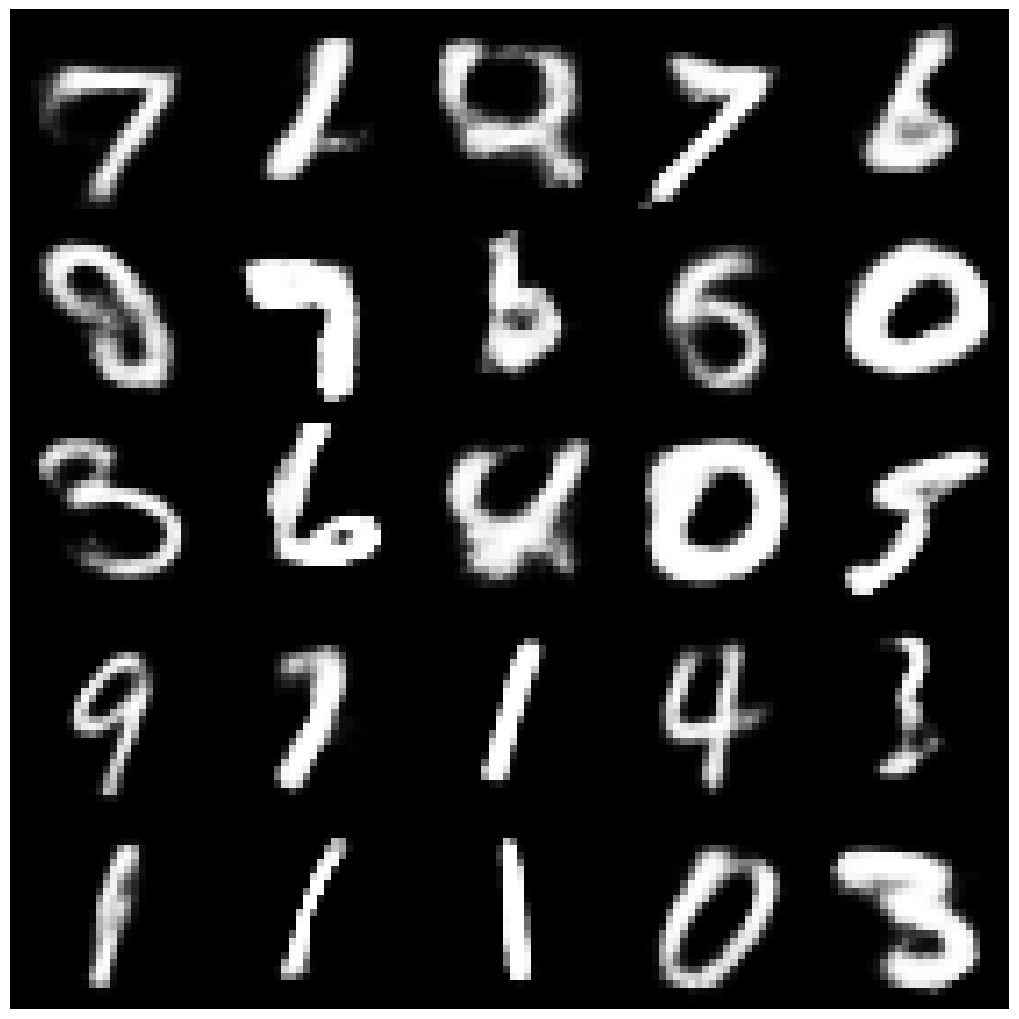

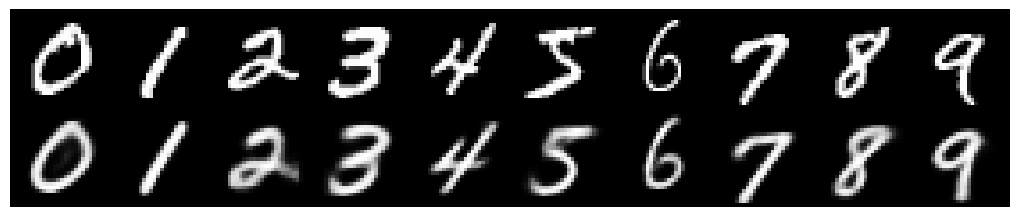

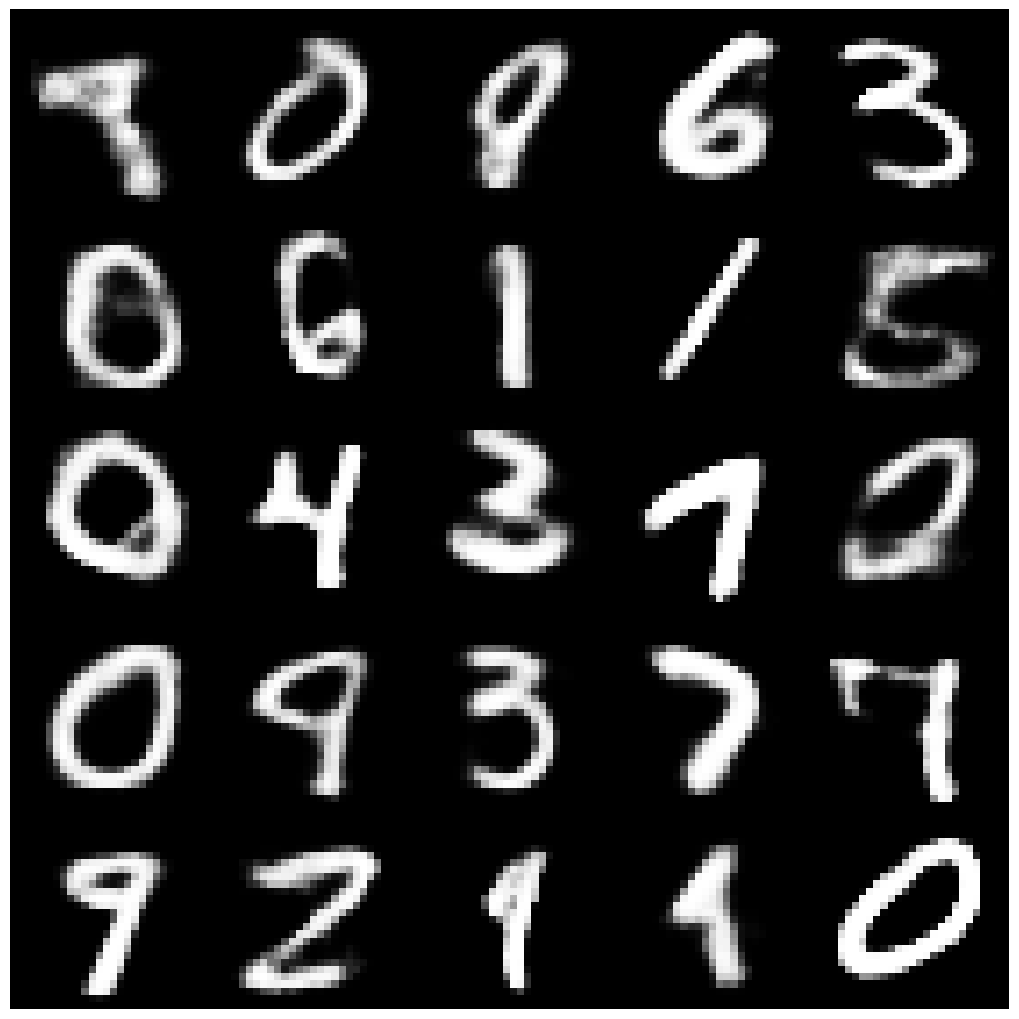

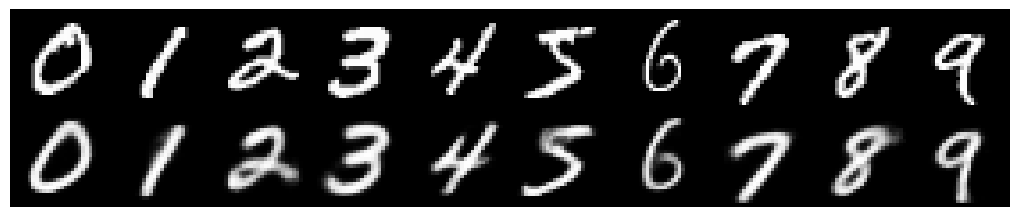

In [ ]:
wandb.agent(sweep_id, train, count=5)